### Imports

In [3]:
import numpy as np
import pandas as pd

import gym
import gym_anytrading
import quantstats as qs

import matplotlib.pyplot as plt

from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv

### Create Env

In [4]:
df = gym_anytrading.datasets.STOCKS_GOOGL.copy()
print(df)
window_size = 10
start_index = window_size
end_index = len(df)

env_maker = lambda: gym.make(
    'stocks-v0',
    df = df,
    window_size = window_size,
    frame_bound = (start_index, end_index)
)

env = DummyVecEnv([env_maker])

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2009-05-22   198.528534   199.524521   196.196198   196.946945   196.946945   
2009-05-26   196.171173   202.702698   195.195190   202.382385   202.382385   
2009-05-27   203.023026   206.136139   202.607605   202.982986   202.982986   
2009-05-28   204.544540   206.016022   202.507507   205.405411   205.405411   
2009-05-29   206.261261   208.823822   205.555557   208.823822   208.823822   
...                 ...          ...          ...          ...          ...   
2018-08-23  1219.880005  1235.170044  1219.349976  1221.160034  1221.160034   
2018-08-24  1226.000000  1237.400024  1221.420044  1236.750000  1236.750000   
2018-08-27  1244.140015  1257.869995  1240.680054  1256.270020  1256.270020   
2018-08-28  1255.900024  1256.560059  1242.969971  1245.859985  1245.859985   
2018-08-29  1255.000000  1267.170044  1252.800049  1

### Train Env

In [7]:
policy_kwargs = dict(net_arch=[64, 'lstm', dict(vf=[128, 128, 128], pi=[64, 64])])
#model = A2C('MlpLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs)
model = A2C('MlpPolicy', env, verbose=1) #, policy_kwargs=policy_kwargs)
model.learn(total_timesteps=1000)

Using cpu device
-------------------------------------
| time/                 |           |
|    fps                | 2672      |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -0.662    |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -1.24     |
|    value_loss         | 6.2       |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 2834     |
|    iterations         | 200      |
|    time_elapsed       | 0        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.69    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | 2.37     |
|    va

### Test Env

In [8]:
env = env_maker()
observation = env.reset()
print(observation[np.newaxis, ...])
print(env)

while True:
    observation = observation[np.newaxis, ...]

    # action = env.action_space.sample()
    action, _states = model.predict(observation)
    observation, reward, done, info = env.step(action)

    # env.render()
    if done:
        print("info:", info)
        break

[[[196.946945   0.      ]
  [202.382385   5.43544 ]
  [202.982986   0.600601]
  [205.405411   2.422425]
  [208.823822   3.418411]
  [213.4935     4.669678]
  [214.414413   0.920913]
  [216.041046   1.626633]
  [220.360367   4.319321]
  [222.382385   2.022018]]]
<StocksEnv<stocks-v0>>
info: {'total_reward': 592.0356800000002, 'total_profit': 0.00041957166798480146, 'position': 0}


### Plot Results

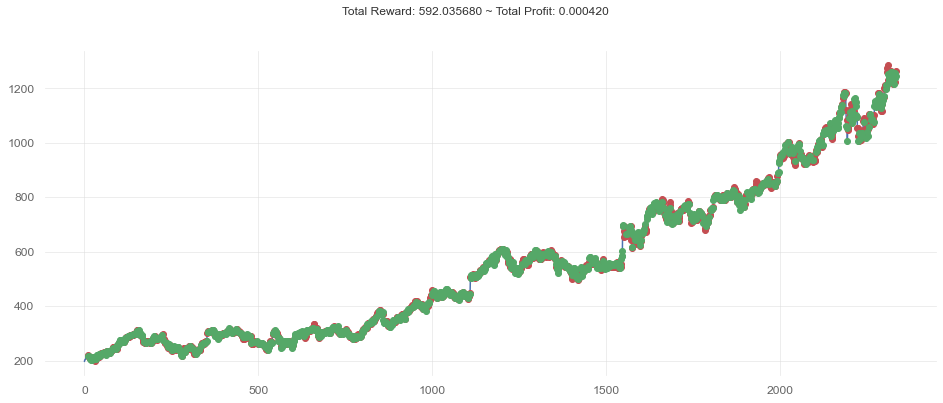

In [9]:
plt.figure(figsize=(16, 6))
env.render_all()
plt.show()

### Analysis Using `quantstats`

                           Strategy
-------------------------  ----------
Start Period               2009-06-10
End Period                 2018-08-29
Risk-Free Rate             0.0%
Time in Market             26.0%

Cumulative Return          -99.96%
CAGR﹪                     -56.96%

Sharpe                     -4.23
Smart Sharpe               -3.94
Sortino                    -4.79
Smart Sortino              -4.46
Sortino/√2                 -3.39
Smart Sortino/√2           -3.15
Omega                      0.18

Max Drawdown               -99.96%
Longest DD Days            3366
Volatility (ann.)          19.46%
Calmar                     -0.57
Skew                       1.14
Kurtosis                   45.49

Expected Daily %           -0.33%
Expected Monthly %         -6.77%
Expected Yearly %          -54.05%
Kelly Criterion            -83.1%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.34%
Expected Shortfall (cVaR)  -2.34%

Gain/Pain Ratio            -0.82
Gain/Pain (1

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2009-06-11,2018-08-22,2018-08-29,3366,-99.958346,-99.955037


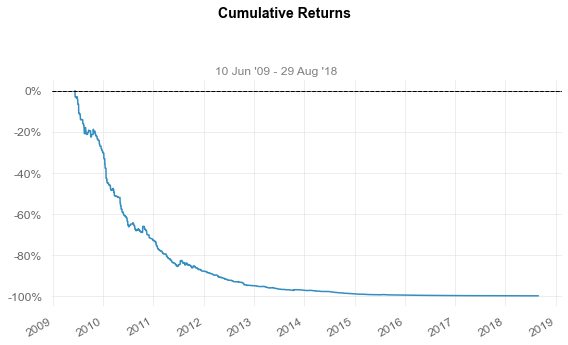

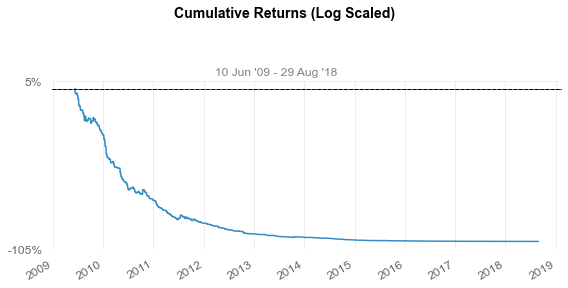

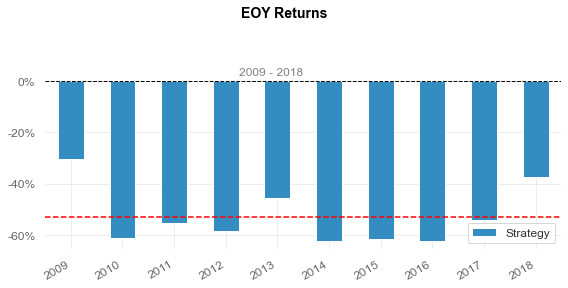

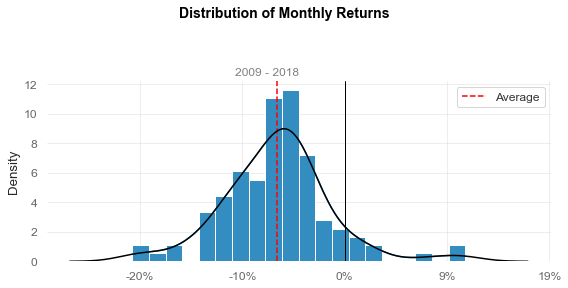

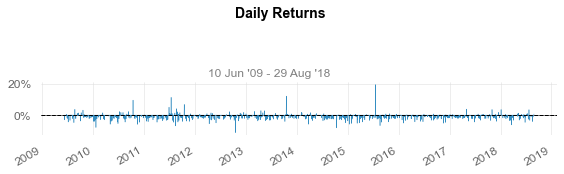

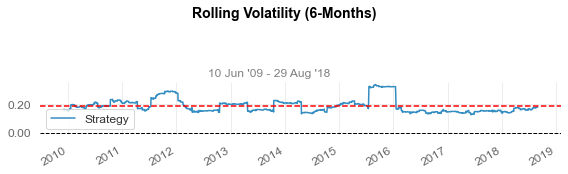

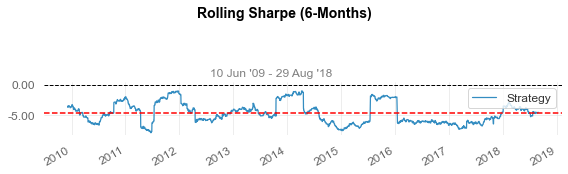

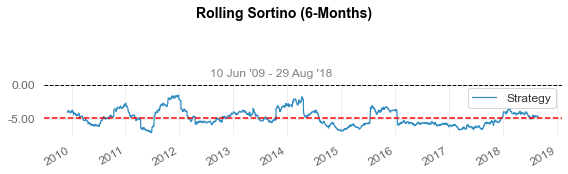

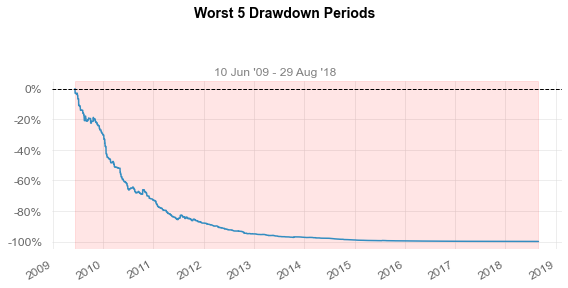

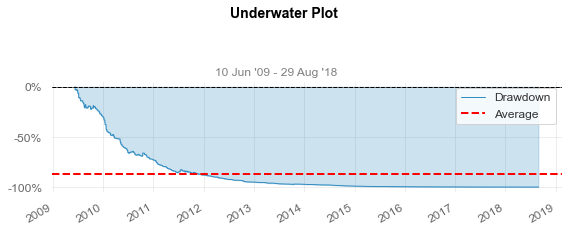

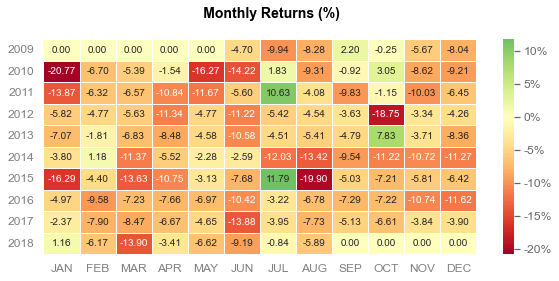

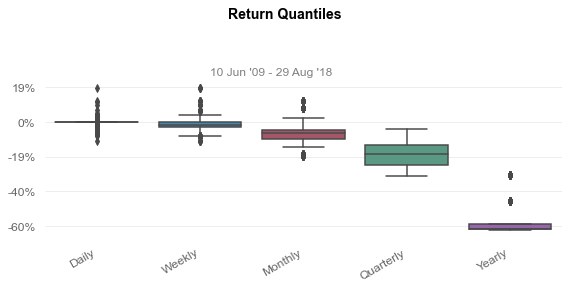

In [15]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output=True) #, download_filename='a2c_quantstats2.html')